City Map

In [1]:
import shapely
print(shapely.__version__)
# print(ig.__version__)

import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd

place = 'St. Louis, Missouri, USA'

G_nx = ox.graph_from_place(place, network_type='drive')

nodes, streets = ox.graph_to_gdfs(G_nx)
streets.head()

# create networkx graph
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

2.0.2


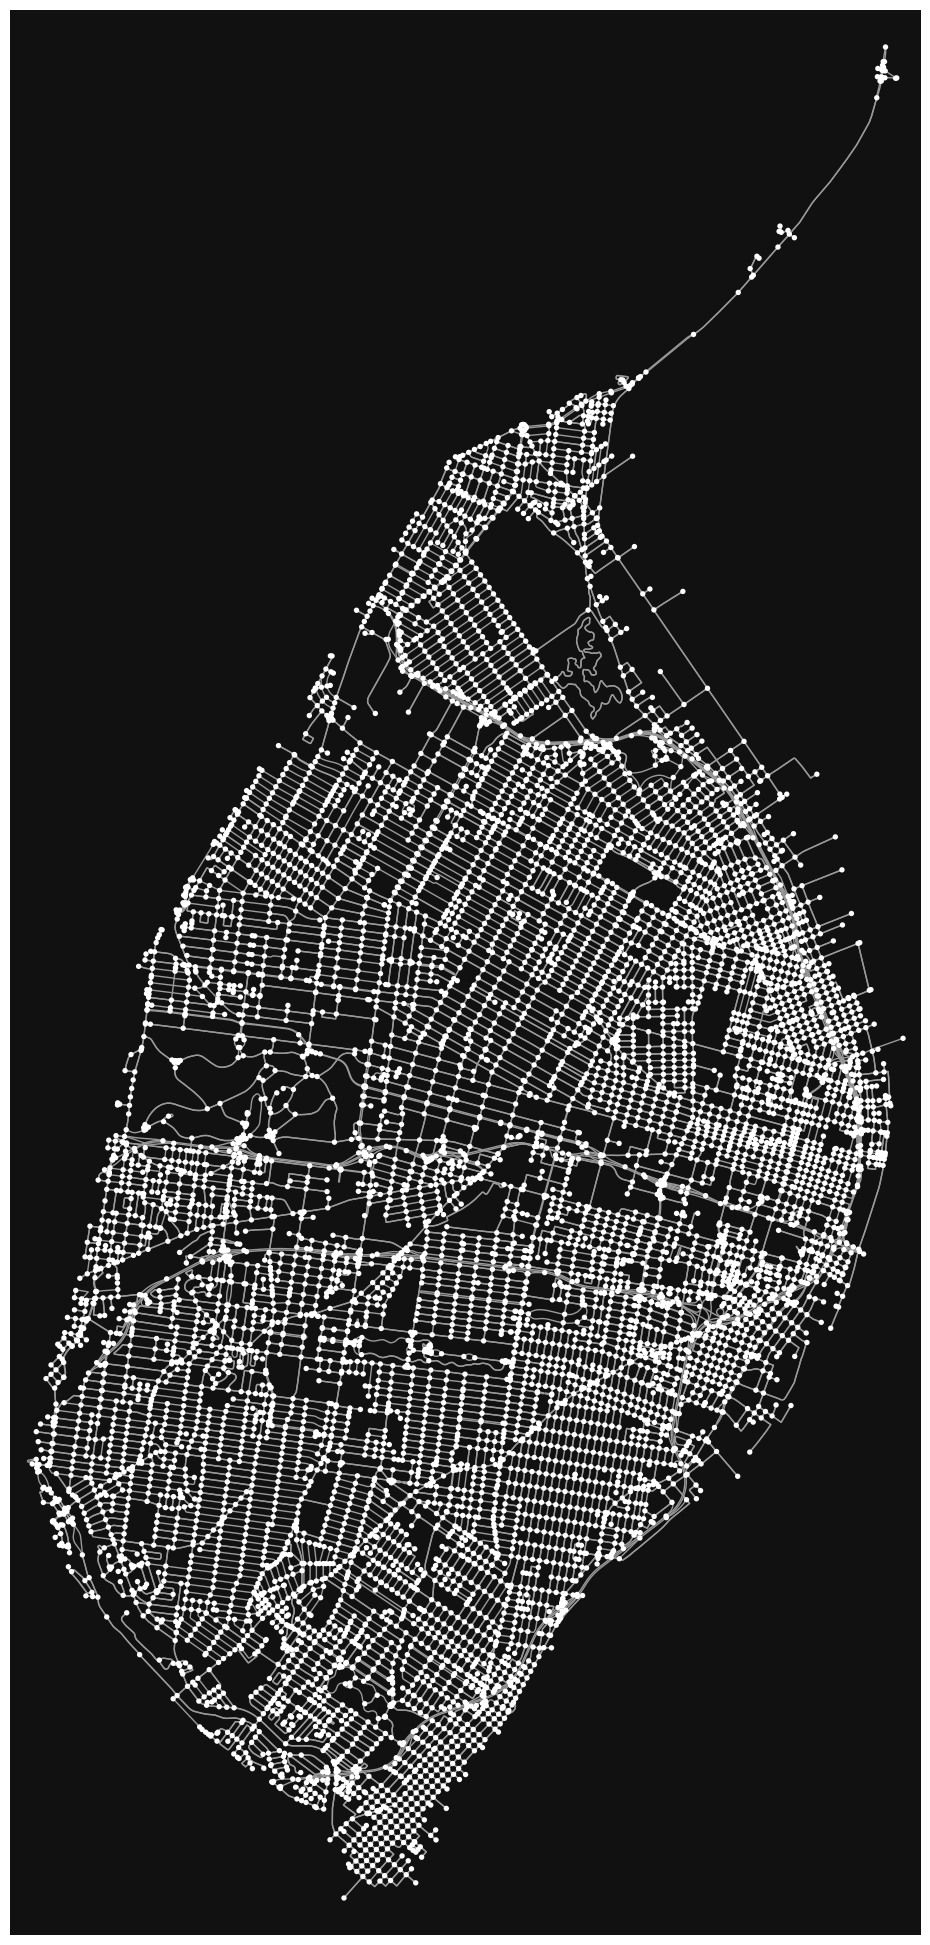

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Get the edges along the shortest path
path_edges = ox.plot_graph(G_nx, figsize = (25,25))

# Show the plot
plt.show()

In [51]:
import networkx as nx
from geopy.distance import geodesic

import igraph as ig
import networkx as nx
import numpy as np
import osmnx as ox

def get_origin_destination_node(coords_origin, coords_destination):
    # Find the nearest nodes in the graph to the specified coordinates
    origin_node = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), coords_origin).kilometers)
    destination_node = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), coords_destination).kilometers)

    print(f"Starting node: {origin_node}")
    print(f"Destination node: {destination_node}")

    return origin_node, destination_node


Genetic Algorithm

In [56]:
import random

import networkx as nx
import matplotlib.pyplot as plt
import random
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
import time

Graph = G_nx

BY_DISTANCE = False

def generate_random_path(graph, start_node, end_node, explore_prob=0.6):
    q = []
    visited = set()

    q.append([start_node])

    while q:
        current_path = q.pop(0)
        last_node = current_path[-1]

        if last_node == end_node:
            return current_path

        if last_node not in visited:
            neighbors = list(graph.neighbors(last_node))

            for neighbor in neighbors:
                if random.random() < explore_prob:
                    new_path = list(current_path)
                    new_path.append(neighbor)
                    q.append(new_path)

            visited.add(last_node)

    return generate_random_path(graph, start_node, end_node)

def calculate_distance(path):
    total_distance = 0

    for node1, node2 in zip(path[:-1], path[1:]):
        coord1 = [Graph.nodes[node1]['y'], Graph.nodes[node1]['x']]
        coord2 = [Graph.nodes[node2]['y'], Graph.nodes[node2]['x']]

        # Function to calculate the haversine distance between two coordinates in (latitude, longitude) format
        R = 6371  # Earth radius in kilometers

        lat1, lon1 = radians(coord1[1]), radians(coord1[0])
        lat2, lon2 = radians(coord2[1]), radians(coord2[0])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        total_distance += distance  # Accumulate distance for each segment

    return total_distance  # Return the total distance for the entire path

def initialize_pop(POP_SIZE, TARGET):

    start_node = TARGET[0][0]
    destination_node = TARGET[0][1]

    population = list()

    i = 0
    while i < POP_SIZE:
        population.append(generate_random_path(Graph, start_node, destination_node))
        i += 1

    return population

def selection(population):
    # Compute lengths of all paths
    path_lengths = [(path, path[-1]) for path in population]

    # Sort paths based on lengths
    sorted_chromo_pop = sorted(path_lengths, key=lambda x: x[1])

    # Select the first 30% of the sorted paths
    selected_paths = [path for path, length in sorted_chromo_pop[:int(0.3 * len(sorted_chromo_pop))]]

    return selected_paths

def fitness_cal(chromo_from_pop):
    path_len = 0
    if BY_DISTANCE:
        path_len = calculate_distance(chromo_from_pop)
    else:
        path_len =  len(chromo_from_pop)
    return [chromo_from_pop, path_len]

def find_common_point(path1, path2):
    # Find all common points between two paths
    common_points = [node for node in path1 if node in path2]

    if not common_points:
        return None  # No common points found

    # Select the middle point
    middle_index = len(common_points) // 2
    middle_point = common_points[middle_index]

    return middle_point

def merge_path(path1, path2):
    common_point = find_common_point(path1, path2)
    if common_point:
        if random.choice([True, False]):  # Randomly decide which path comes first
            index_path1 = path1.index(common_point)
            index_path2 = path2.index(common_point)

            return path1[:index_path1] + path2[index_path2:]
        else:
            index_path2 = path2.index(common_point)
            index_path1 = path1.index(common_point)

            return path2[:index_path2] + path1[index_path1:]

def crossover(population):
    crossovered = []
    for path1 in population:
        
        # randomly pick second parent
        path2 = random.choice(population)

        # take only nodes
        path1 = path1[0]
        path2 = path2[0]

        # Merge two paths by combining the first half of path1 with the second half of path2
        merged_path = merge_path(path1, path2)
        crossovered.append([merged_path, fitness_cal(merged_path)])
    
    return crossovered

def geodesic_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

def mutate_path(path, max_distance_factor):
    for _ in range(5):  # Try up to 5 times to find a suitable mutation
        # Calculate the maximum allowed distance between random points
        max_distance = max_distance_factor * len(path)

        # Choose the first random point
        random_p1 = random.choice(path)

        # Find a candidate for the second random point within the allowed distance
        candidate_points = [node for node in path if geodesic_distance(G_nx.nodes[random_p1]['y'], G_nx.nodes[random_p1]['x'], G_nx.nodes[node]['y'], G_nx.nodes[node]['x']) <= max_distance]

        if not candidate_points:
            continue  # No suitable candidates found, try again

        # Choose the second random point from the candidate points
        random_p2 = random.choice(candidate_points)

        random_path = generate_random_path(G_nx, random_p1, random_p2)
        
        if random_path is not None:
            # Successful mutation, return the modified path
            return path[:path.index(random_p1)] + random_path + path[path.index(random_p2) + 1:]

    # No successful mutation, return the original path
    return path

def mutate(population, max_distance_factor):
    mutated = []
    for path in population:
        # take only nodes
        path = path[0]
        mutated_path = mutate_path(path, max_distance_factor)
        mutated.append([mutated_path, fitness_cal(mutated_path)])
    return mutated
    

def replace(new_gen, population):
    # print(population)
    try:
        for idx in range(len(population)):
            if population[idx][1] > new_gen[idx][1]: #if len of new_gen is smaller
              population[idx][0] = new_gen[idx][0]
              population[idx][1] = new_gen[idx][1]
    except:
        pass
    return population



def genetic_algorithm(POP_SIZE, MUT_RATE, TARGET, GENES, MAX_GENERATIONS, by_distance):

    global BY_DISTANCE
    if by_distance:
        BY_DISTANCE = True

    # 1) initialize population
    initial_population = initialize_pop(POP_SIZE, TARGET)
    found = False
    population = []
    generation = 1

    # Set the maximum execution time in seconds
    max_execution_time = 10

    # Get the start time
    start_time = time.time()

    # 2) Calculating the fitness for the current population
    for path in initial_population:
        population.append(fitness_cal(path))

    # now population has 2 things, [chromosome, fitness]
    # 3) now we loop until TARGET is found
    while generation <= MAX_GENERATIONS:
        
        # 3.1) select best people from current population
        selected = selection(population)

        # 3.2) mate parents to make new generation
        # population = sorted(selected, key= lambda x:x[1])
        crossovered = crossover(selected)
            
        # 3.3) mutating the childeren to diversfy the new generation
        mutated = mutate(crossovered, MUT_RATE)
                
        # 3.4) replacement of bad population with new generation
        # we sort here first to compare the least fit population with the most fit new_gen
        new_gen = []
        for p in mutated:
            new_gen.append(fitness_cal(p[0]))

        population = replace(new_gen, population)
        population = sorted(population, key= lambda x:x[1])
        
        # found = True
        generation+=1

    return population[0][0]

In [5]:
# Set the source and target coordinates
start_coordinates = (38.664172, -90.259974)
destination_coordinates = (38.625559, -90.210021)

TARGET = [get_origin_destination_node(start_coordinates, destination_coordinates)]

Starting node: 4341
Destination node: 6377


Testing with fitness function based on lenght of the path

Distance of the path 8.859805906264095


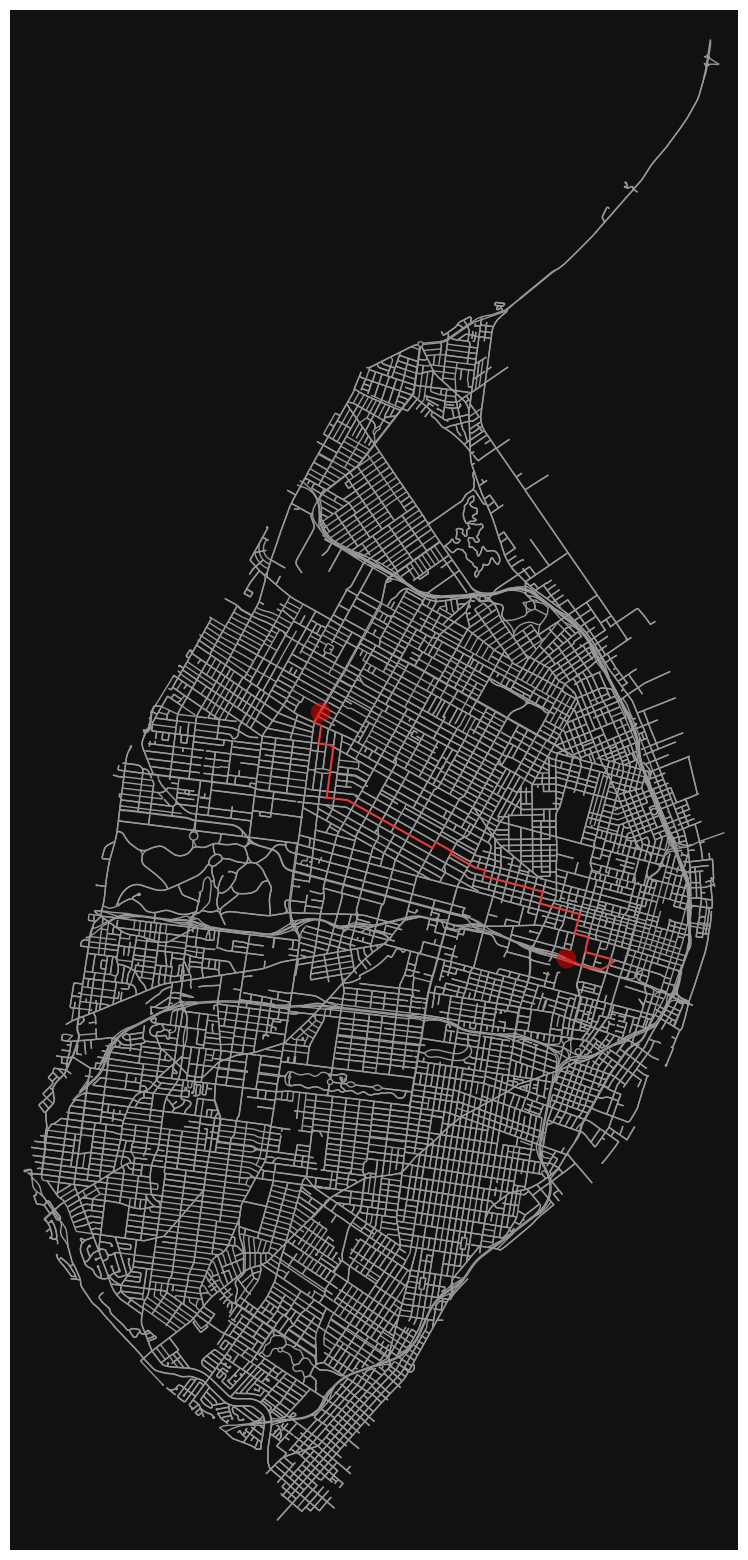

In [63]:
POP_SIZE = 100
MUT_RATE = 0.1
MAX_GENERATIONS = 25
BY_DISTANCE = True
best_path = genetic_algorithm(POP_SIZE, MUT_RATE, TARGET, Graph, MAX_GENERATIONS, BY_DISTANCE)

print(f"Distance of the path {calculate_distance(best_path)}")

# Get the edges along the shortest path
path_edges = ox.plot_graph_route(G_nx, best_path, route_color='r', orig_dest_size=200, route_linewidth=2, show=True, node_size=0, figsize=(20,20))

# Show the plot
plt.show()

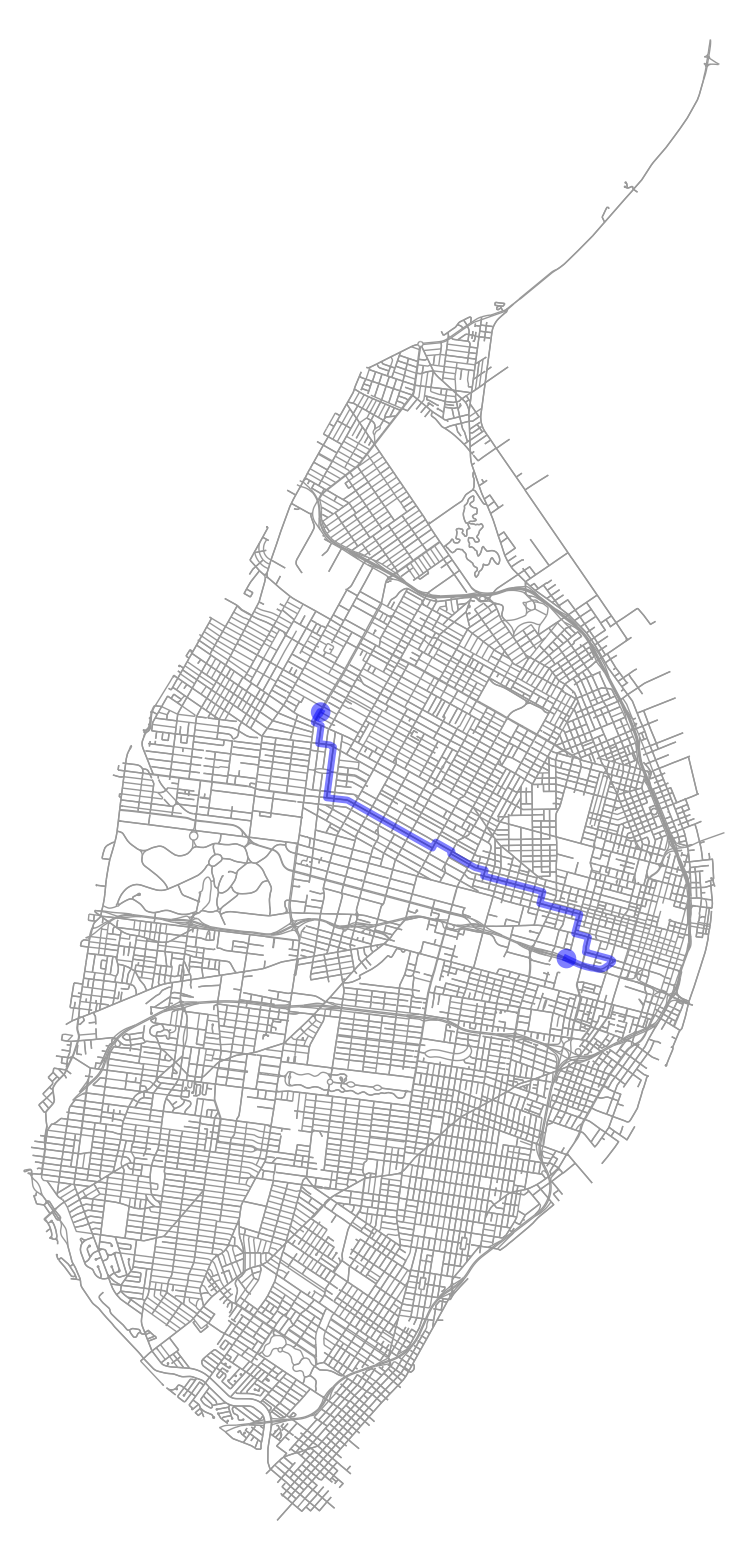

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [65]:
ox.plot_graph_route(G_nx, best_path, route_color='b', orig_dest_size=200, route_linewidth=5, show=True, node_size=0, figsize=(20,20), bgcolor='w')

Testing based on fitness function based on number of nodes

Distance of the path 9.582341422896347


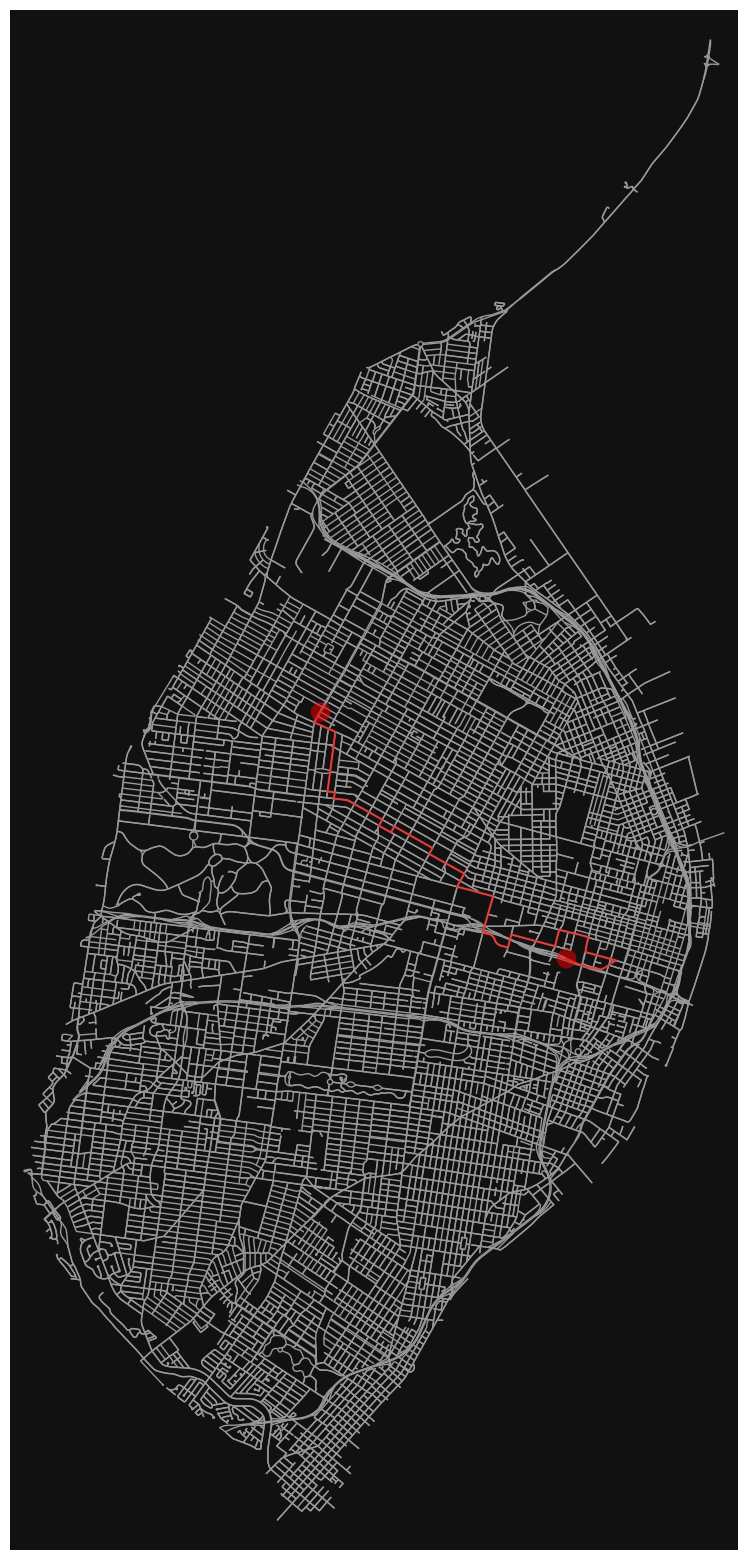

In [58]:
POP_SIZE = 100
MUT_RATE = 0.1
MAX_GENERATIONS = 25
BY_DISTANCE = False
best_path = genetic_algorithm(POP_SIZE, MUT_RATE, TARGET, Graph, MAX_GENERATIONS, BY_DISTANCE)

print(f"Distance of the path {calculate_distance(best_path)}")

# Get the edges along the shortest path
path_edges = ox.plot_graph_route(G_nx, best_path, route_color='r', orig_dest_size=200, route_linewidth=2, show=True, node_size=0, figsize=(20,20))

# Show the plot
plt.show()

Test it pathes are random and merge pathes

In [60]:
# Get the edges along the shortest path
path1 = generate_random_path(Graph, TARGET[0][0],TARGET[0][1])
path2 = generate_random_path(Graph, TARGET[0][0],TARGET[0][1])


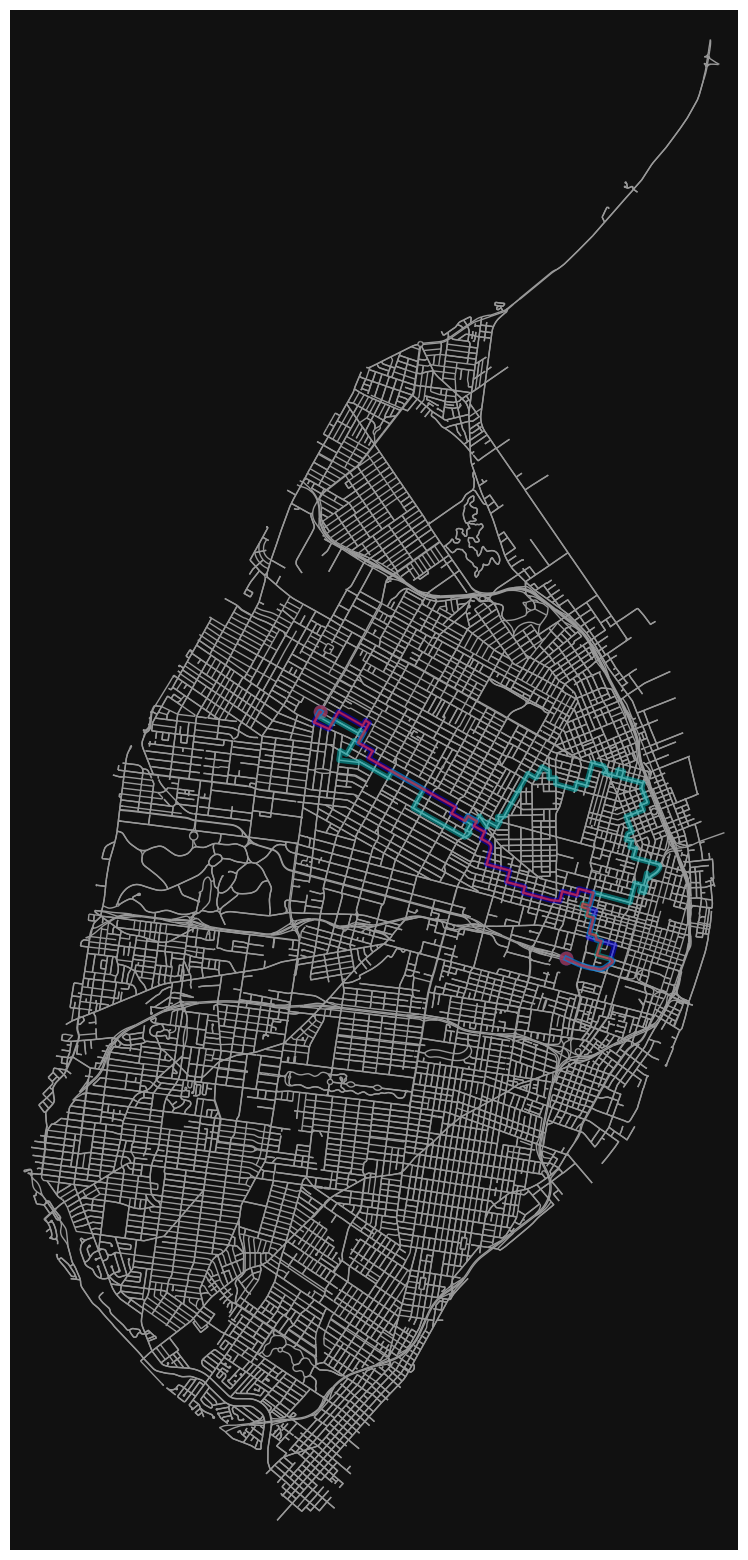

In [61]:
merged_path = merge_path(path1, path2)

routes = [path1, path2, merged_path]
rc = ['b', 'c', 'r']
rl = [4, 4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))

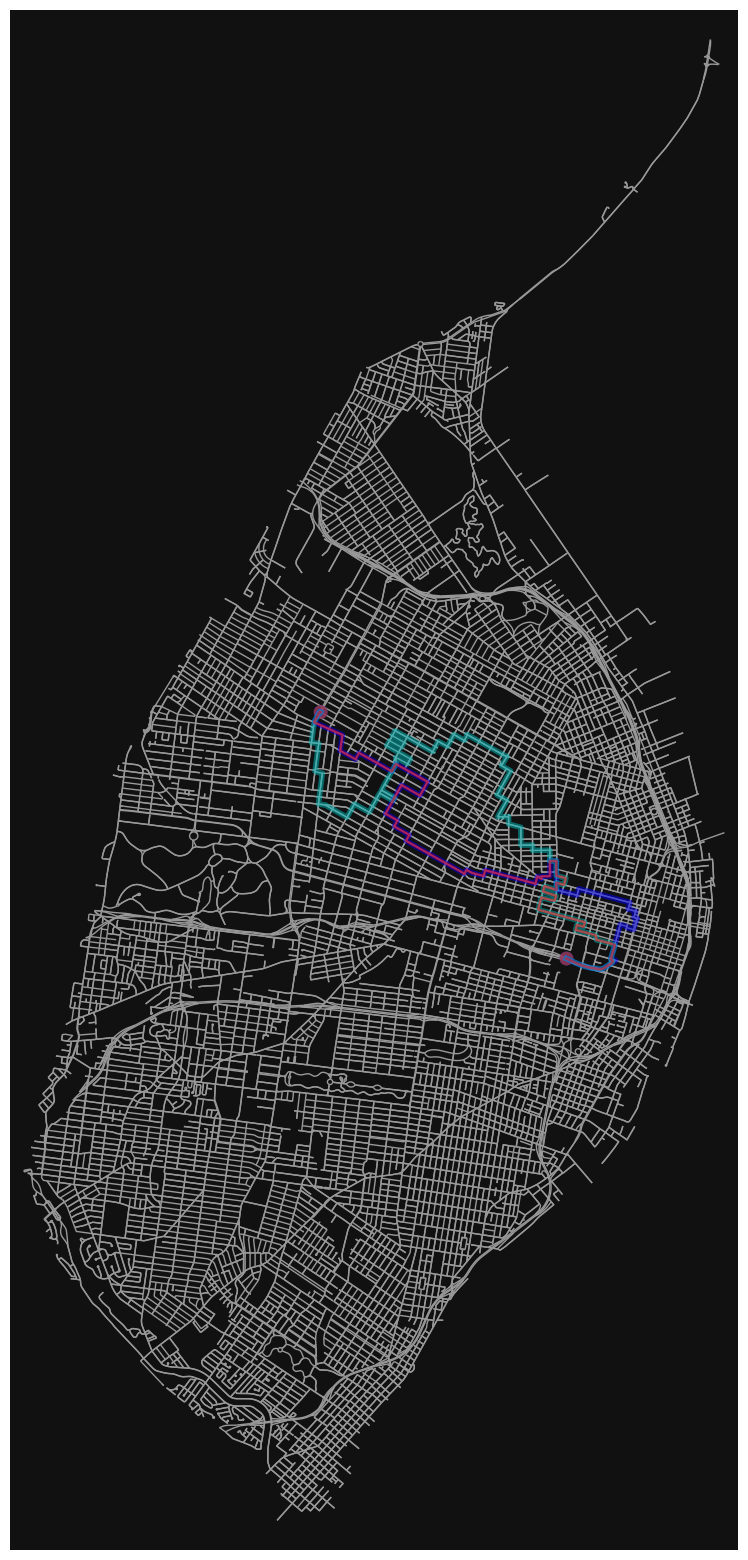

In [10]:
merged_path = merge_path(path1, path2)

routes = [path1, path2, merged_path]
rc = ['b', 'c', 'r']
rl = [4, 4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))

Verify mutation

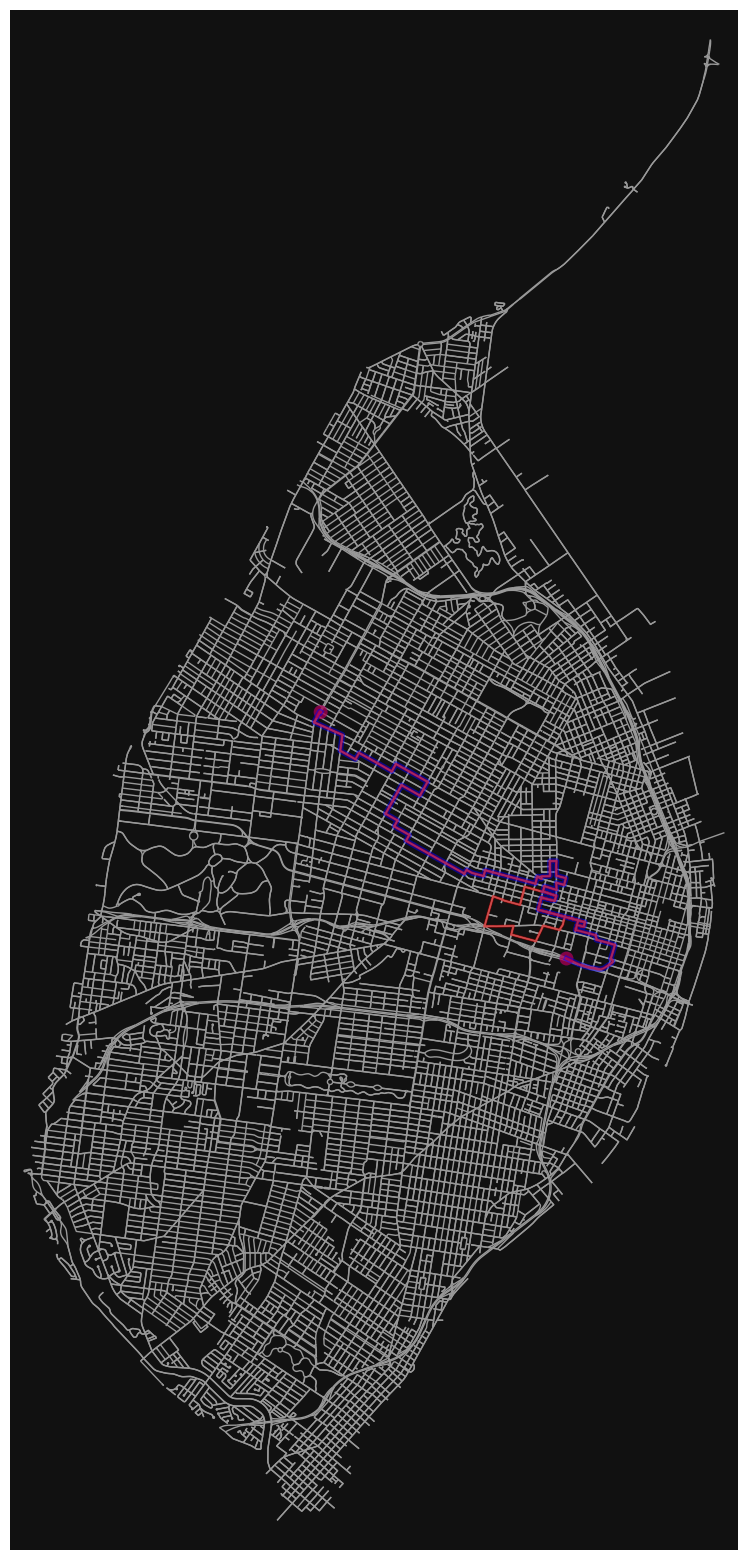

In [11]:
mutated_path = mutate_path(merged_path, 0.2)

routes = [merged_path, mutated_path]
rc = ['b', 'r']
rl = [4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))